In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rc('font', size=12)

# 가설 1. 코로나 발생 이후로 유동인구가 줄었을 것이다.

## 코로나
- covid_19/Time 데이터로 코로나 발생 시기 시각화해서 확인

## 유동인구 
- fpopl, adstrd 데이터를 merge 해서 지역 확인
- 일자별로 유동인구 

In [3]:
fpopl = pd.read_csv("./KT_data_20200717/fpopl.csv")

In [4]:
adstrd = pd.read_csv("./KT_data_20200717/adstrd_master.csv")

In [5]:
covid_time = pd.read_csv("./KT_data_20200717/COVID_19/Time.csv")

In [6]:
covid_time.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


## Covid time 정보
- date 정보를 시계열 data로 변경
- index를 바꿔준 data로 변경
- 확진자 수를 의미하는 confrimed column만 추출
- plot

<AxesSubplot:xlabel='date'>

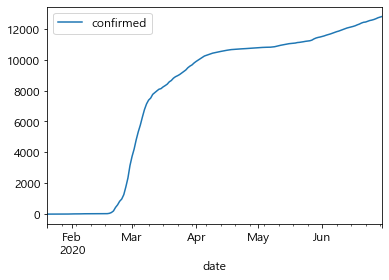

In [7]:
covid_time.date = pd.to_datetime(covid_time.date)

covid_time.set_index(covid_time.date, inplace=True)

del covid_time["date"]

confirmed = covid_time[["confirmed"]]

confirmed.plot()

 # fpopl and adstrd data
-  시기: 2020-01-01 ~ 2020-06-16

## Dimension
- base_ymd : 기준연월일
- tmzon_se_code : 24시간대 구분코드
- sexdstn_se_code : 성별 구분코드 (M:남성, F:여성)
- argde_se_code : 5세단위 연령대 구분코드
- astrd_code : 행정동코드

## Value
- popltn_cascnt : 유동인구 수

## data merge
- fpopl data와 adstrd data를 adstrd_code column을 통해 inner join
- join한 데이터에서 brtc_nm(도시 이름) unique 결과 '서울특별시' 밖에 없음

In [8]:
fpop_m = pd.merge(fpopl, adstrd, on='adstrd_code', how='inner')

fpop_m.brtc_nm.unique()

array(['서울특별시'], dtype=object)

- fpopl 데이터의 경우 base_ymd 가 날짜 구분 없이 단순 수로 되어있기 때문에 (ex: 20200101)
- string type 으로 변경 후, 시계열 데이터로 변경하기 위해 구분자 추가 후 index로 설정

In [9]:
date = fpop_m.base_ymd.astype(str)

date_t = date.tolist()

for i in range(len(date_t)):
    date_t[i] = date_t[i][:4] + "-" + date_t[i][4:6] + "-" + date_t[i][6:]

fpop_m["date"] = date_t

fpop_m.date = pd.to_datetime(fpop_m.date)

fpop_m.set_index(fpop_m.date, inplace=True)

del fpop_m["date"]

del fpop_m["base_ymd"]

fpop_m.head()

,tmzon_se_code,sexdstn_se_code,agrde_se_code,adstrd_code,popltn_cascnt,adstrd_nm,brtc_nm,signgu_nm
date,,,,,,,,
2020-01-01,0,M,age_00,11650560,15,반포1동,서울특별시,서초구
2020-01-01,0,F,age_00,11650560,21,반포1동,서울특별시,서초구
2020-01-01,0,M,age_10,11650560,81,반포1동,서울특별시,서초구
2020-01-01,0,F,age_10,11650560,84,반포1동,서울특별시,서초구
2020-01-01,0,F,age_15,11650560,273,반포1동,서울특별시,서초구


<AxesSubplot:xlabel='date'>

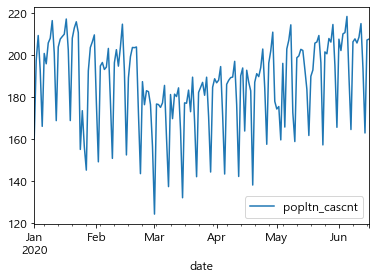

In [10]:
# 일자별 유동인구 plot
date_mean = pd.DataFrame(fpop_m.groupby([fpop_m.index])["popltn_cascnt"].mean())

date_mean.plot()

- 일자별로 보았을 때 데이터를 보기 힘들다고 판단.
- 주 단위로 변경

<AxesSubplot:xlabel='date'>

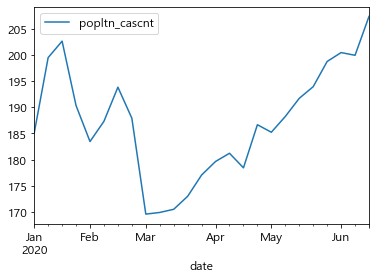

In [11]:
# 주 단위 유동인구 plot
week_mean = pd.DataFrame(fpop_m.popltn_cascnt.resample('W').mean())

week_mean.plot()

<AxesSubplot:xlabel='date', ylabel='popltn_cascnt'>

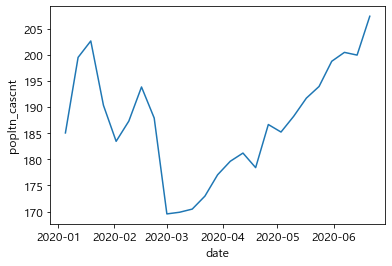

In [12]:
# sns 써보기
sns.lineplot(x=week_mean.index, y=week_mean.popltn_cascnt)

<AxesSubplot:xlabel='date'>

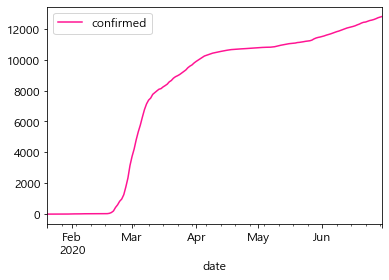

In [13]:
# 전국 확진자 수 추이
confirmed.plot(c = 'deeppink')

## 전국 확진자 수 추이와 서울의 유동인구 데이터

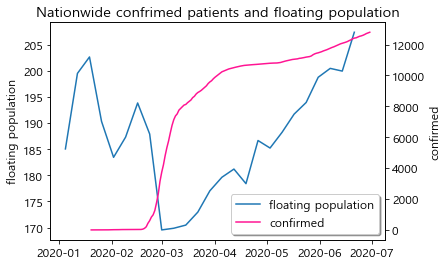

In [14]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('floating population')
popl = ax1.plot(week_mean.index, week_mean.popltn_cascnt, label="floating population")

ax2 = ax1.twinx()
ax2.set_ylabel('confirmed')
confirmed_l = ax2.plot(confirmed.index, confirmed.confirmed, color='deeppink', label="confirmed")

lines = popl + confirmed_l
labels = [i.get_label() for i in lines]
ax1.legend(lines, labels, shadow=True, fancybox=True, loc="lower right")

plt.title("Nationwide confrimed patients and floating population")

plt.show()

- 서울의 유동인구 데이터이므로 서울의 확진자 수 추이와 비교 해야한다고 생각

In [15]:
covid_timeprovince = pd.read_csv("./KT_data_20200717/COVID_19/TimeProvince.csv")

covid_timeprovince.date = pd.to_datetime(covid_timeprovince.date)

covid_timeprovince.set_index(covid_timeprovince.date, inplace=True)

del covid_timeprovince["date"]

covid_timeprovince

,time,province,confirmed,released,deceased
date,,,,,
2020-01-20,16,서울,0,0,0
2020-01-20,16,부산,0,0,0
2020-01-20,16,대구,0,0,0
2020-01-20,16,인천,1,0,0
2020-01-20,16,광주,0,0,0
...,...,...,...,...,...
2020-06-30,0,전라북도,27,21,0
2020-06-30,0,전라남도,24,19,0
2020-06-30,0,경상북도,1389,1328,54


In [16]:
province_grouped = covid_timeprovince.groupby([covid_timeprovince.index,"province"])["confirmed"].first()

pv_df = province_grouped.unstack()

seoul = pv_df[["서울"]]

seoul

province,서울
date,
2020-01-20,0
2020-01-21,0
2020-01-22,0
2020-01-23,0
2020-01-24,0
...,...
2020-06-26,1267
2020-06-27,1284
2020-06-28,1298


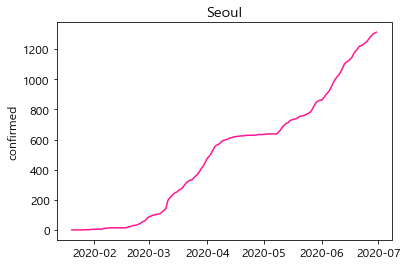

In [17]:
# 서울의 확진자 수 추이
plt.plot(seoul.index, seoul["서울"], c = "deeppink")

plt.title("Seoul")
plt.ylabel('confirmed')

plt.show()

## 서울 확진자 수 추이와 서울의 유동인구 데이터

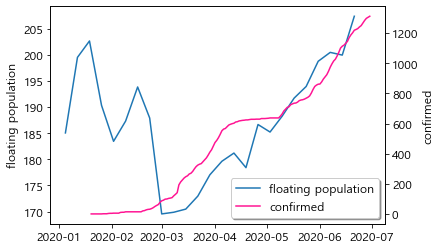

In [18]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('floating population')
popl_2 = ax1.plot(week_mean.index, week_mean.popltn_cascnt, label="floating population")

ax2 = ax1.twinx()
ax2.set_ylabel('confirmed')
confirmed_l_2 = ax2.plot(seoul.index, seoul["서울"], color='deeppink', label="confirmed")

lines = popl_2 + confirmed_l_2
labels = [i.get_label() for i in lines]
ax1.legend(lines, labels, shadow=True, fancybox=True, loc="lower right")

plt.show()

- 코로나 본격적 확산시기(2020.3)에 유동인구가 확 줄어든 것을 확인 할 수 있었다.
- 코로나 사태로 인해 사람들이 외출을 꺼리면서 유동인구는 코로나 사태 전 보다 줄어들 것으로 예상했다.
- 3월에서 5월까지의 유동인구는 코로나 사태 전 상황보다 적은 것을 볼 수 있다.
- 하지만 5월 이후에 유동인구는 다시 이전 수준으로 돌아왔고, 서울시의 확진자수도 함께 증가하였다.

In [19]:
seoul

province,서울
date,
2020-01-20,0
2020-01-21,0
2020-01-22,0
2020-01-23,0
2020-01-24,0
...,...
2020-06-26,1267
2020-06-27,1284
2020-06-28,1298


In [20]:
date_mean

,popltn_cascnt
date,
2020-01-01,159.768264
2020-01-02,197.419462
2020-01-03,209.325962
2020-01-04,192.751830
2020-01-05,166.078805
...,...
2020-06-12,214.991812
2020-06-13,193.474268
2020-06-14,162.928876


In [21]:
# 유동인구가 가장 적은날 찾기 : 2020-03-01
date_mean.idxmin()

popltn_cascnt   2020-03-01
dtype: datetime64[ns]

In [22]:
corr_data = pd.merge(date_mean, seoul, left_index=True, right_index=True, how="inner")

In [23]:
np.where(corr_data.index == "2020-03-01")

(array([41], dtype=int64),)

In [24]:
# 피어슨 상관계수 사용
corr_data[41:].corr(method='pearson')

,popltn_cascnt,서울
popltn_cascnt,1.000000,0.505073
서울,0.505073,1.000000


### 피어슨 상관계수 의미
#### 상관관계가 인과관계를 의미하는 것은 아니다. 단순히 두 변수의 연관성을 확인하는 것이다.
- -1.0과 -0.7 사이이면, 강한 음적 선형관계
- -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계
- -0.3과 -0.1 사이이면, 약한 음적 선형관계
- -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계
- +0.1과 +0.3 사이이면, 약한 양적 선형관계
- +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계
- +0.7과 +1.0 사이이면, 강한 양적 선형관계

# 가설 2. 확진자가 많이 나타난 지역은 다른 지역에 비해 배달이용 건수가 증가했을 것이다.

## 지역별 확진자 데이터
- 지역별로 누적 확진자 수를 바탕으로 지역 구분

## 배달이용건수
- 확진자가 많은 지역과 적은 지역을 나눠서 배달 이용 건수 추이를 확인
- 전체 배달 이용건수 추이를 확인

In [25]:
# 2020-06-30 일 데이터가 있는 index 찾기
np.where(covid_timeprovince.index == "2020-06-30")

(array([2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
        2765, 2766, 2767, 2768, 2769, 2770], dtype=int64),)

In [26]:
last_confirmed = covid_timeprovince[2754:]

last_confirmed.head()

,time,province,confirmed,released,deceased
date,,,,,
2020-06-30,0,서울,1312,985,7
2020-06-30,0,부산,154,142,3
2020-06-30,0,대구,6906,6700,189
2020-06-30,0,인천,341,290,1
2020-06-30,0,광주,44,32,0


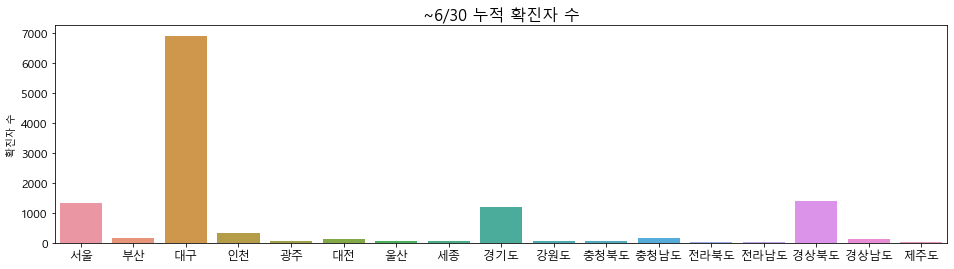

In [27]:
plt.figure(figsize=(16,4))
sns.barplot(x="province", y="confirmed", data=last_confirmed)
plt.title("~6/30 누적 확진자 수",fontsize=16)
plt.xlabel("")
plt.ylabel("확진자 수", fontsize=10)

plt.show()

- 가장 많은 지역 : 대구
- 다른 지역에 비해 많이 발생한 지역 : 서울 , 경기도, 경상북도
- 확진자 수가 적은 지역 : 나머지

## Delivery Data

- PROCESS_DT : 처리일시
- DLVR_STORE_ID : 배달상점ID
- DLVR_STORE_SIDO : 배달상점 주소 법정동 시도명
- DLVR_STORE_INDUTY_NM : 배달상점 업종이름
- DLVR_DSTN_SIDO : 배달목적지 주소 법정동 시도명
- DLVR_DSTN_SIGUNGU : 배달목적지 주소 법정동 시군구명
- DLVR_DSTN_DONG : 배달목적지 주소 법정동 읍면동명
- DLVR_DSTN_ADSTRD_CODE : 배달목적지 주소 행정동 코드
- DLVR_DSTN_RDNMADR_CODE : 배달목적지주소 도로명주소 코드
- GOODS_AMOUNT : 배달상품금액
- SETLE_KND_VALUE : 결제종류번호 (1:카드, 2:선불, 3:현금)
- DLVR_RCEPT_TIME : 배달접수시간

In [28]:
delivery = pd.read_csv("./KT_data_20200717/delivery.csv")
delivery.head()

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
0,4577985,2020-01-01,C000035,1,C000035,S0032342,치킨,4812710600,경상남도,창원시 마산회원구,...,D0005271,4290,300,25000,1,승인:비씨카드사,2020-01-01 00:15:49,2020-01-01 00:21:38,2020-01-01 00:41:37,NaN
1,4577986,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121010200,경기도,광명시,...,D0003269,4800,200,49000,2,NaN,2020-01-01 01:12:14,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,...,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN
3,4577989,2020-01-01,C000029,1,C000043,S0039634,한식,4115010100,경기도,의정부시,...,D0005061,4500,300,20000,2,NaN,2020-01-01 01:01:34,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN
4,4577991,2020-01-01,C000130,1,C000130,S0002237,한식,4128112800,경기도,고양시 덕양구,...,D0005215,6500,300,32000,2,NaN,2020-01-01 01:05:06,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN


In [29]:
np.where(delivery["DLVR_DSTN_SIDO"].isnull() == True)[0].shape

(389543,)

In [30]:
np.where(delivery["DLVR_STORE_SIDO"].isnull() == True)[0].shape

(0,)

- 도착지의 시도 정보가 빈 값이 많아서 빈 값이 없는 상점의 위치로 진행 (시도 단위로 진행해서 크게 상관없다고 생각)

In [31]:
delivery["DLVR_STORE_SIDO"].unique()

array(['경상남도', '경기도', '서울특별시', '전라남도', '대구광역시', '충청남도', '제주특별자치도', '전라북도',
       '경상북도', '인천광역시', '대전광역시', '부산광역시', '충청북도', '광주광역시', '강원도'],
      dtype=object)

In [32]:
delivery.PROCESS_DT = pd.to_datetime(delivery.PROCESS_DT)

In [33]:
sum_delivery = delivery.groupby(["PROCESS_DT","DLVR_STORE_SIDO"]).size().unstack()

In [34]:
delivery_sum_week = sum_delivery.resample('W').sum()
delivery_sum_week.head()

DLVR_STORE_SIDO,강원도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,서울특별시,인천광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도
PROCESS_DT,,,,,,,,,,,,,,,
2020-01-05,351.0,79062.0,7837.0,5762.0,489.0,3222.0,1637.0,2692.0,23931.0,2460.0,1044.0,3035.0,1703.0,4296.0,2347.0
2020-01-12,425.0,120130.0,11924.0,10760.0,264.0,4653.0,2129.0,3908.0,34973.0,3656.0,1467.0,4660.0,2609.0,6585.0,3540.0
2020-01-19,346.0,105218.0,10728.0,9764.0,757.0,4191.0,2088.0,2178.0,31025.0,3494.0,1428.0,3869.0,2358.0,5854.0,2927.0
2020-01-26,357.0,88669.0,10206.0,7983.0,98.0,3196.0,1911.0,164.0,25883.0,3266.0,1234.0,3887.0,2694.0,5182.0,2819.0
2020-02-02,479.0,115306.0,12324.0,10414.0,223.0,4418.0,2275.0,373.0,33593.0,3968.0,1353.0,4193.0,2698.0,6241.0,3527.0


<AxesSubplot:xlabel='PROCESS_DT'>

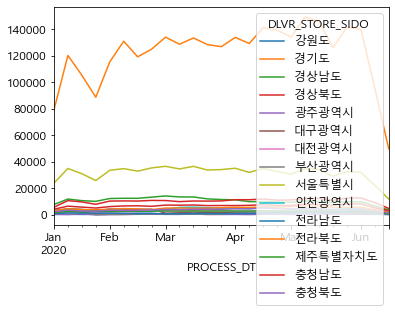

In [35]:
delivery_sum_week.plot()

- 경기도가 배달 데이터의 많은 비중을 차지하고 있음을 알 수 있음

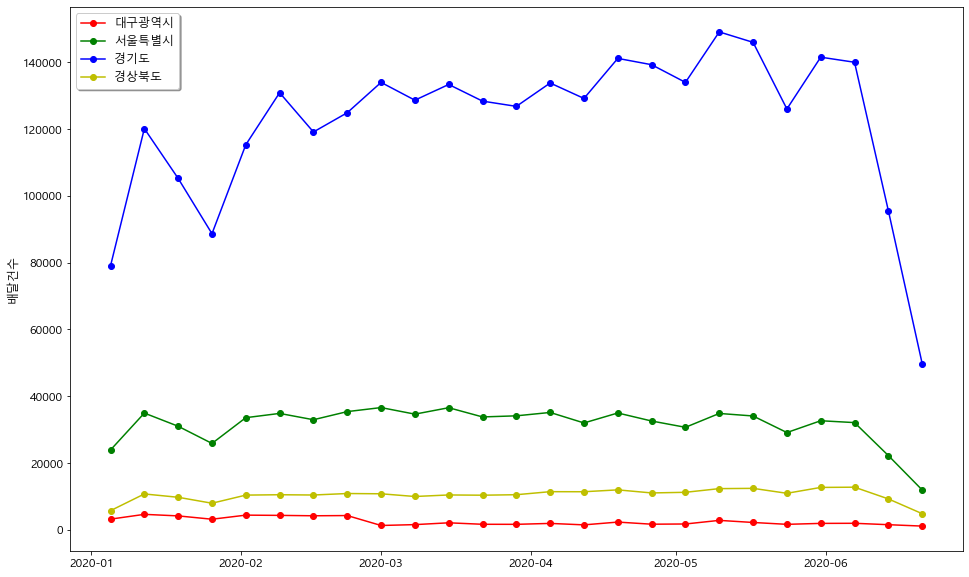

In [36]:
plt.figure(figsize=(16,10))

plt.plot(delivery_sum_week.index, delivery_sum_week["대구광역시"], label="대구광역시", c = "r", marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["서울특별시"], label="서울특별시", c = "g", marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["경기도"], label="경기도", c = 'b', marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["경상북도"], label="경상북도", c = 'y', marker = "o")
plt.legend(shadow=True, fancybox=True, loc="upper left")

plt.ylabel("배달건수")

plt.show()

In [37]:
delivery_sum_week.columns

Index(['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '인천광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도'],
      dtype='object', name='DLVR_STORE_SIDO')

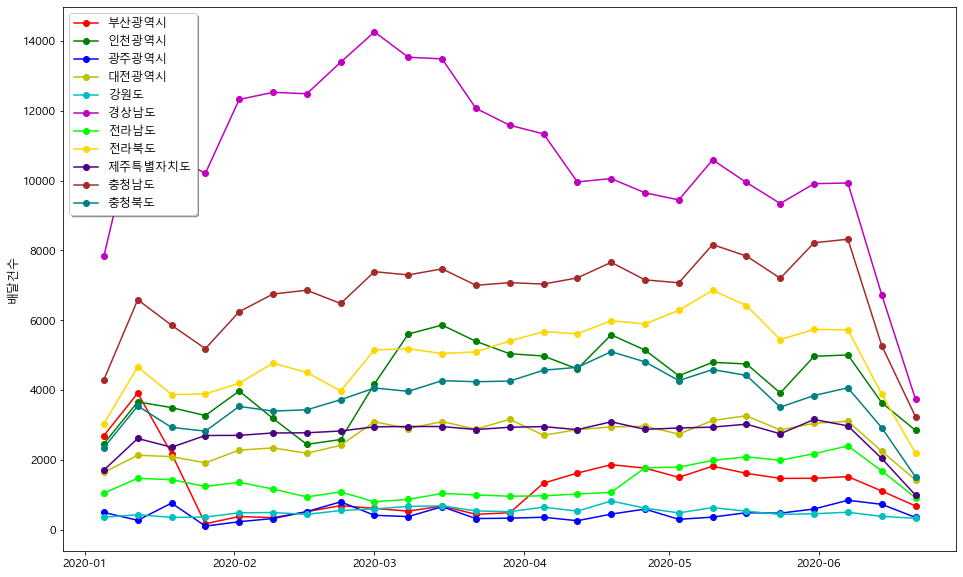

In [38]:
plt.figure(figsize=(16,10))

plt.plot(delivery_sum_week.index, delivery_sum_week["부산광역시"], label="부산광역시", c = "r", marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["인천광역시"], label="인천광역시", c = "g", marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["광주광역시"], label="광주광역시", c = 'b', marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["대전광역시"], label="대전광역시", c = 'y', marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["강원도"], label="강원도", c = 'c', marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["경상남도"], label="경상남도", c = 'm', marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["전라남도"], label="전라남도", c = 'lime', marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["전라북도"], label="전라북도", c = 'gold', marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["제주특별자치도"], label="제주특별자치도", c = 'indigo', marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["충청남도"], label="충청남도", c = 'brown', marker = "o")
plt.plot(delivery_sum_week.index, delivery_sum_week["충청북도"], label="충청북도", c = 'teal', marker = "o")

plt.legend(shadow=True, fancybox=True, loc="upper left")

plt.ylabel("배달건수")

plt.show()

In [39]:
delivery_sum_month = sum_delivery.resample('M').sum()
delivery_sum_month.head()

DLVR_STORE_SIDO,강원도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,서울특별시,인천광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도
PROCESS_DT,,,,,,,,,,,,,,,
2020-01-31,1769.0,466774.0,48646.0,41114.0,1755.0,18146.0,9197.0,9171.0,136943.0,15269.0,6088.0,18296.0,11230.0,25674.0,13986.0
2020-02-29,2110.0,527072.0,54752.0,44581.0,2040.0,15465.0,10334.0,2181.0,145942.0,12934.0,4200.0,18880.0,11703.0,28582.0,15085.0
2020-03-31,2687.0,572448.0,55779.0,45865.0,1787.0,7947.0,13268.0,2386.0,154268.0,24132.0,4281.0,22867.0,12953.0,32019.0,18444.0
2020-04-30,2657.0,585052.0,43173.0,48976.0,1741.0,7469.0,12254.0,7166.0,142626.0,21578.0,5525.0,25088.0,12483.0,31108.0,20413.0
2020-05-31,2287.0,622881.0,44255.0,53812.0,2013.0,9825.0,13508.0,7081.0,144934.0,20306.0,9063.0,27502.0,13221.0,34632.0,18273.0


In [40]:
delivery_sum_month = delivery_sum_month.set_index(delivery_sum_month.index.month)

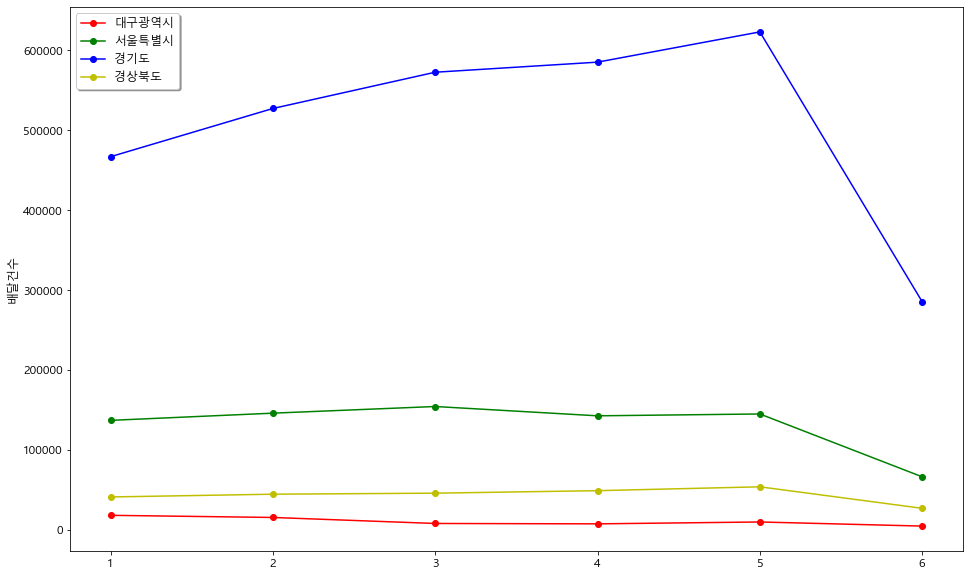

In [41]:
plt.figure(figsize=(16,10))

plt.plot(delivery_sum_month.index, delivery_sum_month["대구광역시"], label="대구광역시", c = "r", marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["서울특별시"], label="서울특별시", c = "g", marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["경기도"], label="경기도", c = 'b', marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["경상북도"], label="경상북도", c = 'y', marker = "o")
plt.legend(shadow=True, fancybox=True, loc="upper left")

plt.ylabel("배달건수")

plt.show()

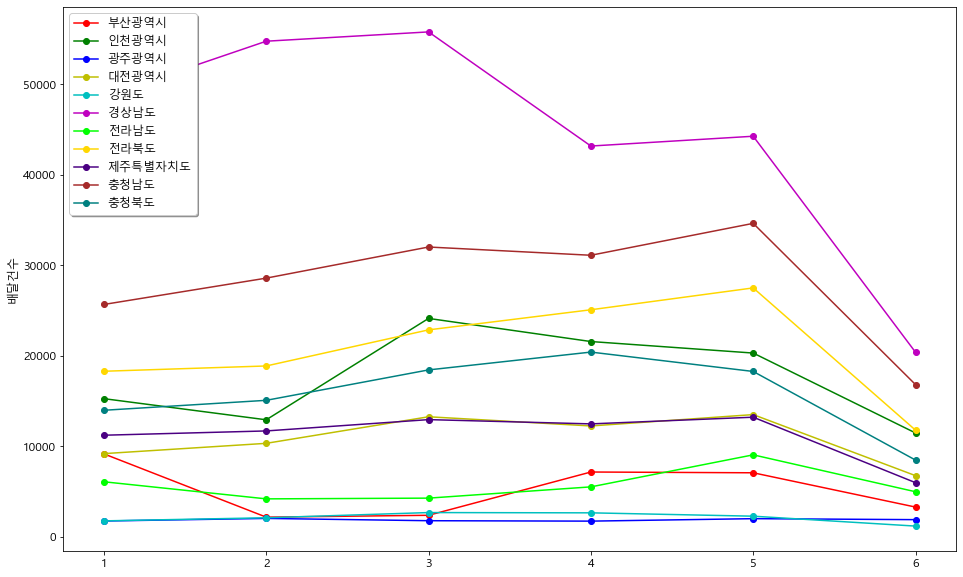

In [42]:
plt.figure(figsize=(16,10))

plt.plot(delivery_sum_month.index, delivery_sum_month["부산광역시"], label="부산광역시", c = "r", marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["인천광역시"], label="인천광역시", c = "g", marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["광주광역시"], label="광주광역시", c = 'b', marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["대전광역시"], label="대전광역시", c = 'y', marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["강원도"], label="강원도", c = 'c', marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["경상남도"], label="경상남도", c = 'm', marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["전라남도"], label="전라남도", c = 'lime', marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["전라북도"], label="전라북도", c = 'gold', marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["제주특별자치도"], label="제주특별자치도", c = 'indigo', marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["충청남도"], label="충청남도", c = 'brown', marker = "o")
plt.plot(delivery_sum_month.index, delivery_sum_month["충청북도"], label="충청북도", c = 'teal', marker = "o")

plt.legend(shadow=True, fancybox=True, loc="upper left")

plt.ylabel("배달건수")

plt.show()

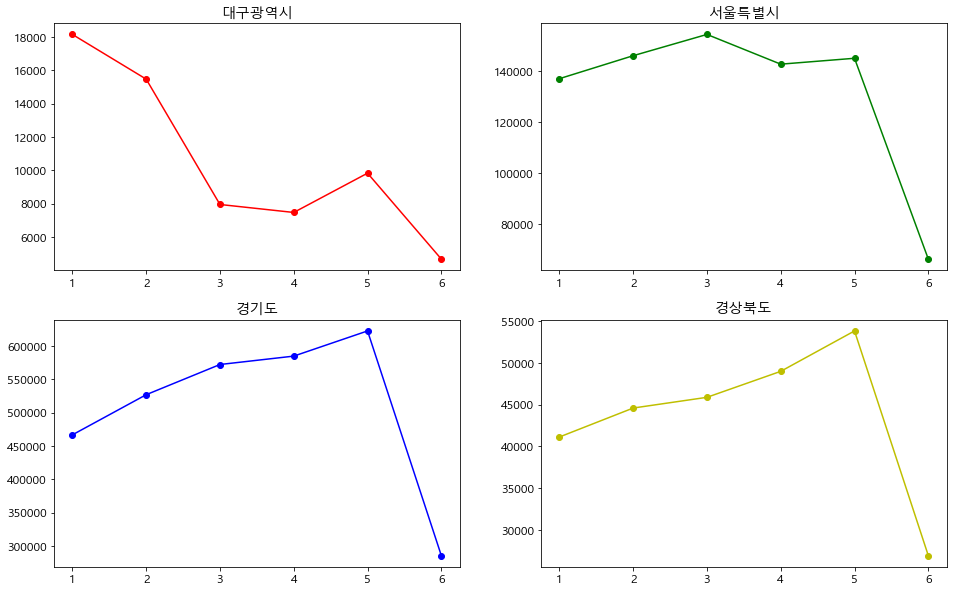

In [43]:
fig = plt.figure() 
fig.set_size_inches(16,10)  
ax_1 = fig.add_subplot(2,2,1) 
ax_2 = fig.add_subplot(2,2,2) 
ax_3 = fig.add_subplot(2,2,3) 
ax_4 = fig.add_subplot(2,2,4) 

ax_1.plot(delivery_sum_month.index, delivery_sum_month["대구광역시"], label="대구광역시", c = "r", marker = "o")
ax_2.plot(delivery_sum_month.index, delivery_sum_month["서울특별시"], label="서울특별시", c = "g", marker = "o")
ax_3.plot(delivery_sum_month.index, delivery_sum_month["경기도"], label="경기도", c = 'b', marker = "o")
ax_4.plot(delivery_sum_month.index, delivery_sum_month["경상북도"], label="경상북도", c = 'y', marker = "o")

ax_1.set_title("대구광역시")
ax_2.set_title("서울특별시")
ax_3.set_title("경기도")
ax_4.set_title("경상북도")

plt.show()

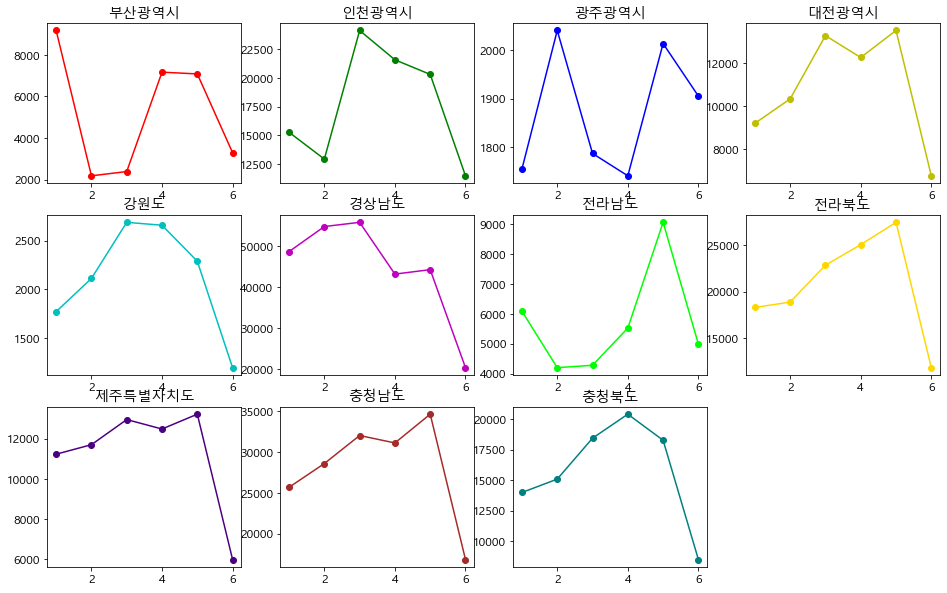

In [44]:
fig = plt.figure() 
fig.set_size_inches(16,10)

ax_1 = fig.add_subplot(3,4,1) 
ax_2 = fig.add_subplot(3,4,2) 
ax_3 = fig.add_subplot(3,4,3) 
ax_4 = fig.add_subplot(3,4,4) 
ax_5 = fig.add_subplot(3,4,5) 
ax_6 = fig.add_subplot(3,4,6) 
ax_7 = fig.add_subplot(3,4,7) 
ax_8 = fig.add_subplot(3,4,8) 
ax_9 = fig.add_subplot(3,4,9) 
ax_10 = fig.add_subplot(3,4,10) 
ax_11 = fig.add_subplot(3,4,11) 

ax_1.plot(delivery_sum_month.index, delivery_sum_month["부산광역시"], label="부산광역시", c = "r", marker = "o")
ax_2.plot(delivery_sum_month.index, delivery_sum_month["인천광역시"], label="인천광역시", c = "g", marker = "o")
ax_3.plot(delivery_sum_month.index, delivery_sum_month["광주광역시"], label="광주광역시", c = 'b', marker = "o")
ax_4.plot(delivery_sum_month.index, delivery_sum_month["대전광역시"], label="대전광역시", c = 'y', marker = "o")
ax_5.plot(delivery_sum_month.index, delivery_sum_month["강원도"], label="강원도", c = 'c', marker = "o")
ax_6.plot(delivery_sum_month.index, delivery_sum_month["경상남도"], label="경상남도", c = 'm', marker = "o")
ax_7.plot(delivery_sum_month.index, delivery_sum_month["전라남도"], label="전라남도", c = 'lime', marker = "o")
ax_8.plot(delivery_sum_month.index, delivery_sum_month["전라북도"], label="전라북도", c = 'gold', marker = "o")
ax_9.plot(delivery_sum_month.index, delivery_sum_month["제주특별자치도"], label="제주특별자치도", c = 'indigo', marker = "o")
ax_10.plot(delivery_sum_month.index, delivery_sum_month["충청남도"], label="충청남도", c = 'brown', marker = "o")
ax_11.plot(delivery_sum_month.index, delivery_sum_month["충청북도"], label="충청북도", c = 'teal', marker = "o")

ax_1.set_title("부산광역시")
ax_2.set_title("인천광역시")
ax_3.set_title("광주광역시")
ax_4.set_title("대전광역시")
ax_5.set_title("강원도")
ax_6.set_title("경상남도")
ax_7.set_title("전라남도")
ax_8.set_title("전라북도")
ax_9.set_title("제주특별자치도")
ax_10.set_title("충청남도")
ax_11.set_title("충청북도")

plt.show()

### 전체 배달 건수 합

In [45]:
total = delivery.groupby("PROCESS_DT").count()[["SERIAL_NUMBER"]].resample("M").sum()
total = total.set_index(total.index.month)

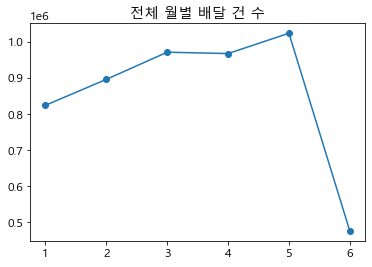

In [46]:
plt.plot(total.index, total["SERIAL_NUMBER"], marker = "o")

plt.title("전체 월별 배달 건 수")

plt.show()

In [47]:
total_k_out = delivery_sum_month.drop("경기도", axis =1).sum(axis=1)

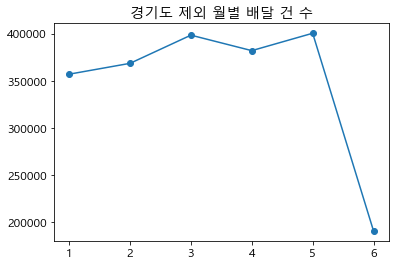

In [48]:
plt.plot(total_k_out.index, total_k_out.values, marker = "o")

plt.title("경기도 제외 월별 배달 건 수")

plt.show()

- 많은 지역에서 코로나 사태 이후 배달 이용 건수가 증가하였다.
- 하지만 코로나 확진자가 가장 많이 발생한 지역인 대구에서는 오히려 배달 이용 건수가 줄어 드는 것을 볼 수 있다.
- 현재 배달 데이터의 상당부분을 경기도가 차지하고 있기 때문에 전체 배달 데이터의 흐름은 경기도를 따르고있다고 생각했다.(In[29] 참조)
- 따라서 경기도의 데이터를 뺀 나머지 데이터를 합하여 똑같이 표현해 보았다.
- 경기도를 뺀 데이터에서도 배달 건 수는 증가하고 있는 것처럼 보인다.
- 나의 가설은 코로나 확진자가 많이 발생한 지역은 적게 발생한 지역에 비해 배달 건 수가 더 많이 증가한다는 것이었는데, 지역과 상관없이 전국적으로 배달 건 수가 늘어났다고 볼 수 있다.